# Introduction to Data Science – Homework 5
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 23, 2024, 11:59pm.

In this homework you will use linear regression to study house prices in Salt Lake City.

## Your Data
Fill out the following information: 

*First Name: Logan*   
*Last Name: Correa*   
*E-mail: logan.correa@utah.edu*     
*UID: u1094034*  


## Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 ([SLC avenues neighborhood](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...). 


### Task 1: Import the data 
Use the [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to import the dataset. The data is contained in two files located in the same directory as this notebook: [`train1.csv`](train1.csv) and [`train2.csv`](train2.csv). After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [71]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
from sklearn import linear_model
import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [72]:
train1 = pd.read_csv('train1.csv')
train2 = pd.read_csv('train2.csv')

house = pd.concat([train1, train2])

### Task 2: Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 300,000 and 900,000 dollars both inclusive. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision – what attributes of a house are important to you? 
You should at least keep the following variables since questions below will use them: `` ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [`str.replace()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lecture. In particular, convert 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 
$$
\text{Prop\_Type\_num}_i = \begin{cases} 
2 & \text{if $i$-th listing is a townhouse} \\
1 & \text{if $i$-th listing is a condo} \\
0 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [73]:
# Filter List Price and desired columns
house_clean = house[(house['LstPrice'] > 300000) & (house['LstPrice'] < 900000)]
house_clean = house_clean[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# Check data types and convert to numeric
house_clean.dtypes
house_clean['TotSqf'] = pd.to_numeric(house_clean['Acres'], errors='coerce')

# Add Prop_Type_num column
house_clean['Prop_Type_num'] = house_clean['PropType'].map({'Single Family': 0, 'Townhouse': 2, 'Condo': 1})
house_clean.head()

# Remove Rows with Longitude of 0
house_clean = house_clean[house_clean.Longitude != 0]

# Remove rows with 2 largest Taxes
house_clean = house_clean[~house_clean['Taxes'].isin(house_clean['Taxes'].nlargest(2))]

display(house_clean)

,Acres,Deck,GaragCap,Latitude,Longitude,DaysOnMkt,LstPrice,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
0,0.29,1,3,40.779524,-111.893542,7.0,725000,0,Single Family,752000,7244,4.0,5.0,0.29,1998,0
2,0.11,0,0,40.773972,-111.867470,4.0,390000,0,Single Family,390000,1816,3.0,1.0,0.11,1940,0
3,0.14,0,1,40.783009,-111.872100,12.0,445000,3,Single Family,443000,3260,3.0,2.0,0.14,1940,0
5,0.01,0,2,40.771693,-111.886951,12.0,339000,2,Condo,334000,2141,3.0,2.0,0.01,1976,1
6,0.14,1,2,40.783889,-111.872194,NaN,600000,2,Single Family,570000,4197,3.0,3.0,0.14,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.12,1,1,40.771219,-111.856599,185.0,533800,0,Single Family,529000,3928,3.0,3.0,0.12,1898,0
142,0.15,1,2,40.779253,-111.893385,203.0,549000,4,Townhouse,535000,3870,5.0,4.0,0.15,1998,2
144,0.01,0,2,40.770904,-111.886201,198.0,349999,2,Condo,340000,1877,2.0,2.0,0.01,1979,1
146,0.07,0,1,40.772835,-111.854867,375.0,330000,0,Single Family,310000,2079,5.0,3.0,0.07,1886,0


### Task 3: Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see `vmin` and `vmax` parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html))
    - Show a legend
    - Make sure the proper labels are visible and readable (see [`xticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [`yticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. Color-code the dots by property type. For the plot, only use a subset of the columns: `['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt' ]`. Determine which columns have strong correlations. 

+ Describing your findings. 


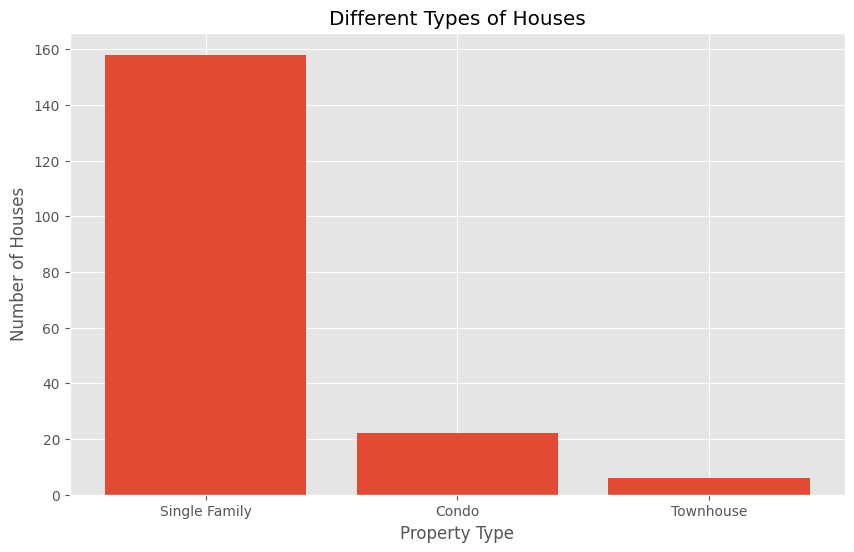

In [74]:
# explore dataset
house_clean.describe()

# Property type bar chart
plt.bar(house_clean['PropType'].unique(), house_clean['PropType'].value_counts())
plt.title('Different Types of Houses')
plt.xlabel('Property Type')
plt.ylabel('Number of Houses')
plt.show()

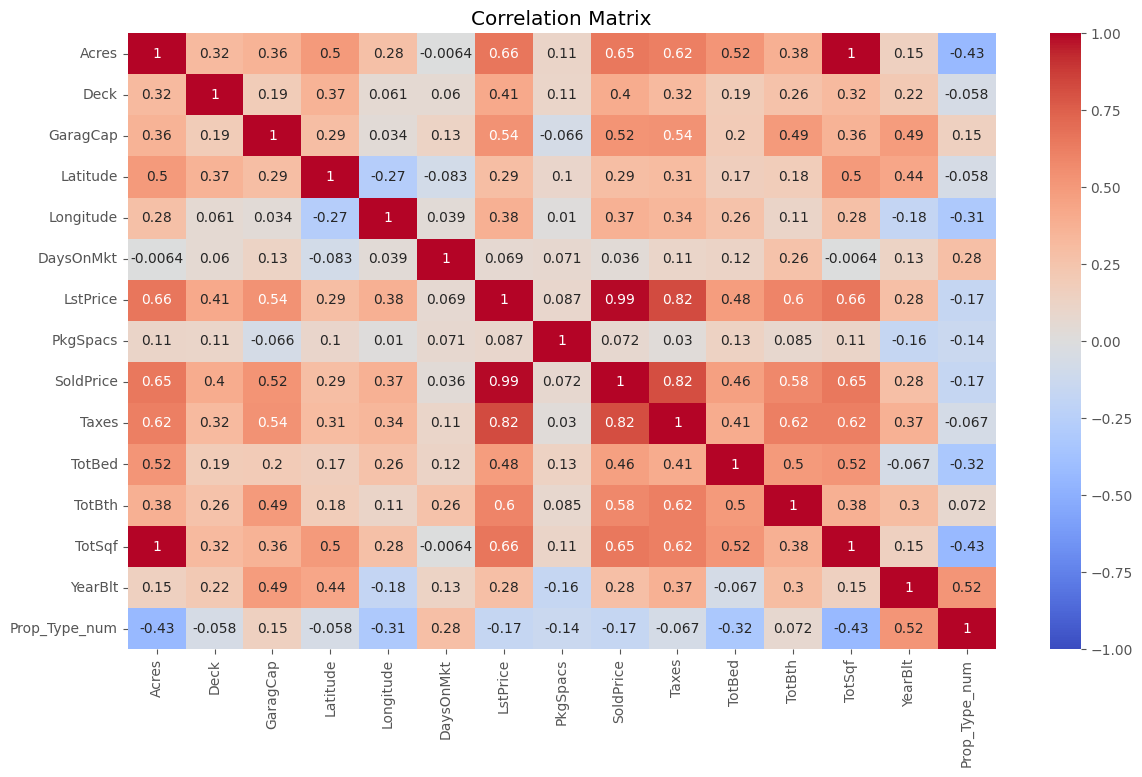

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove non-numeric columns and compute correlation matrix
house_numeric = house_clean.drop(columns=['PropType'])
correlation_matrix = house_numeric.corr()

# Plot correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


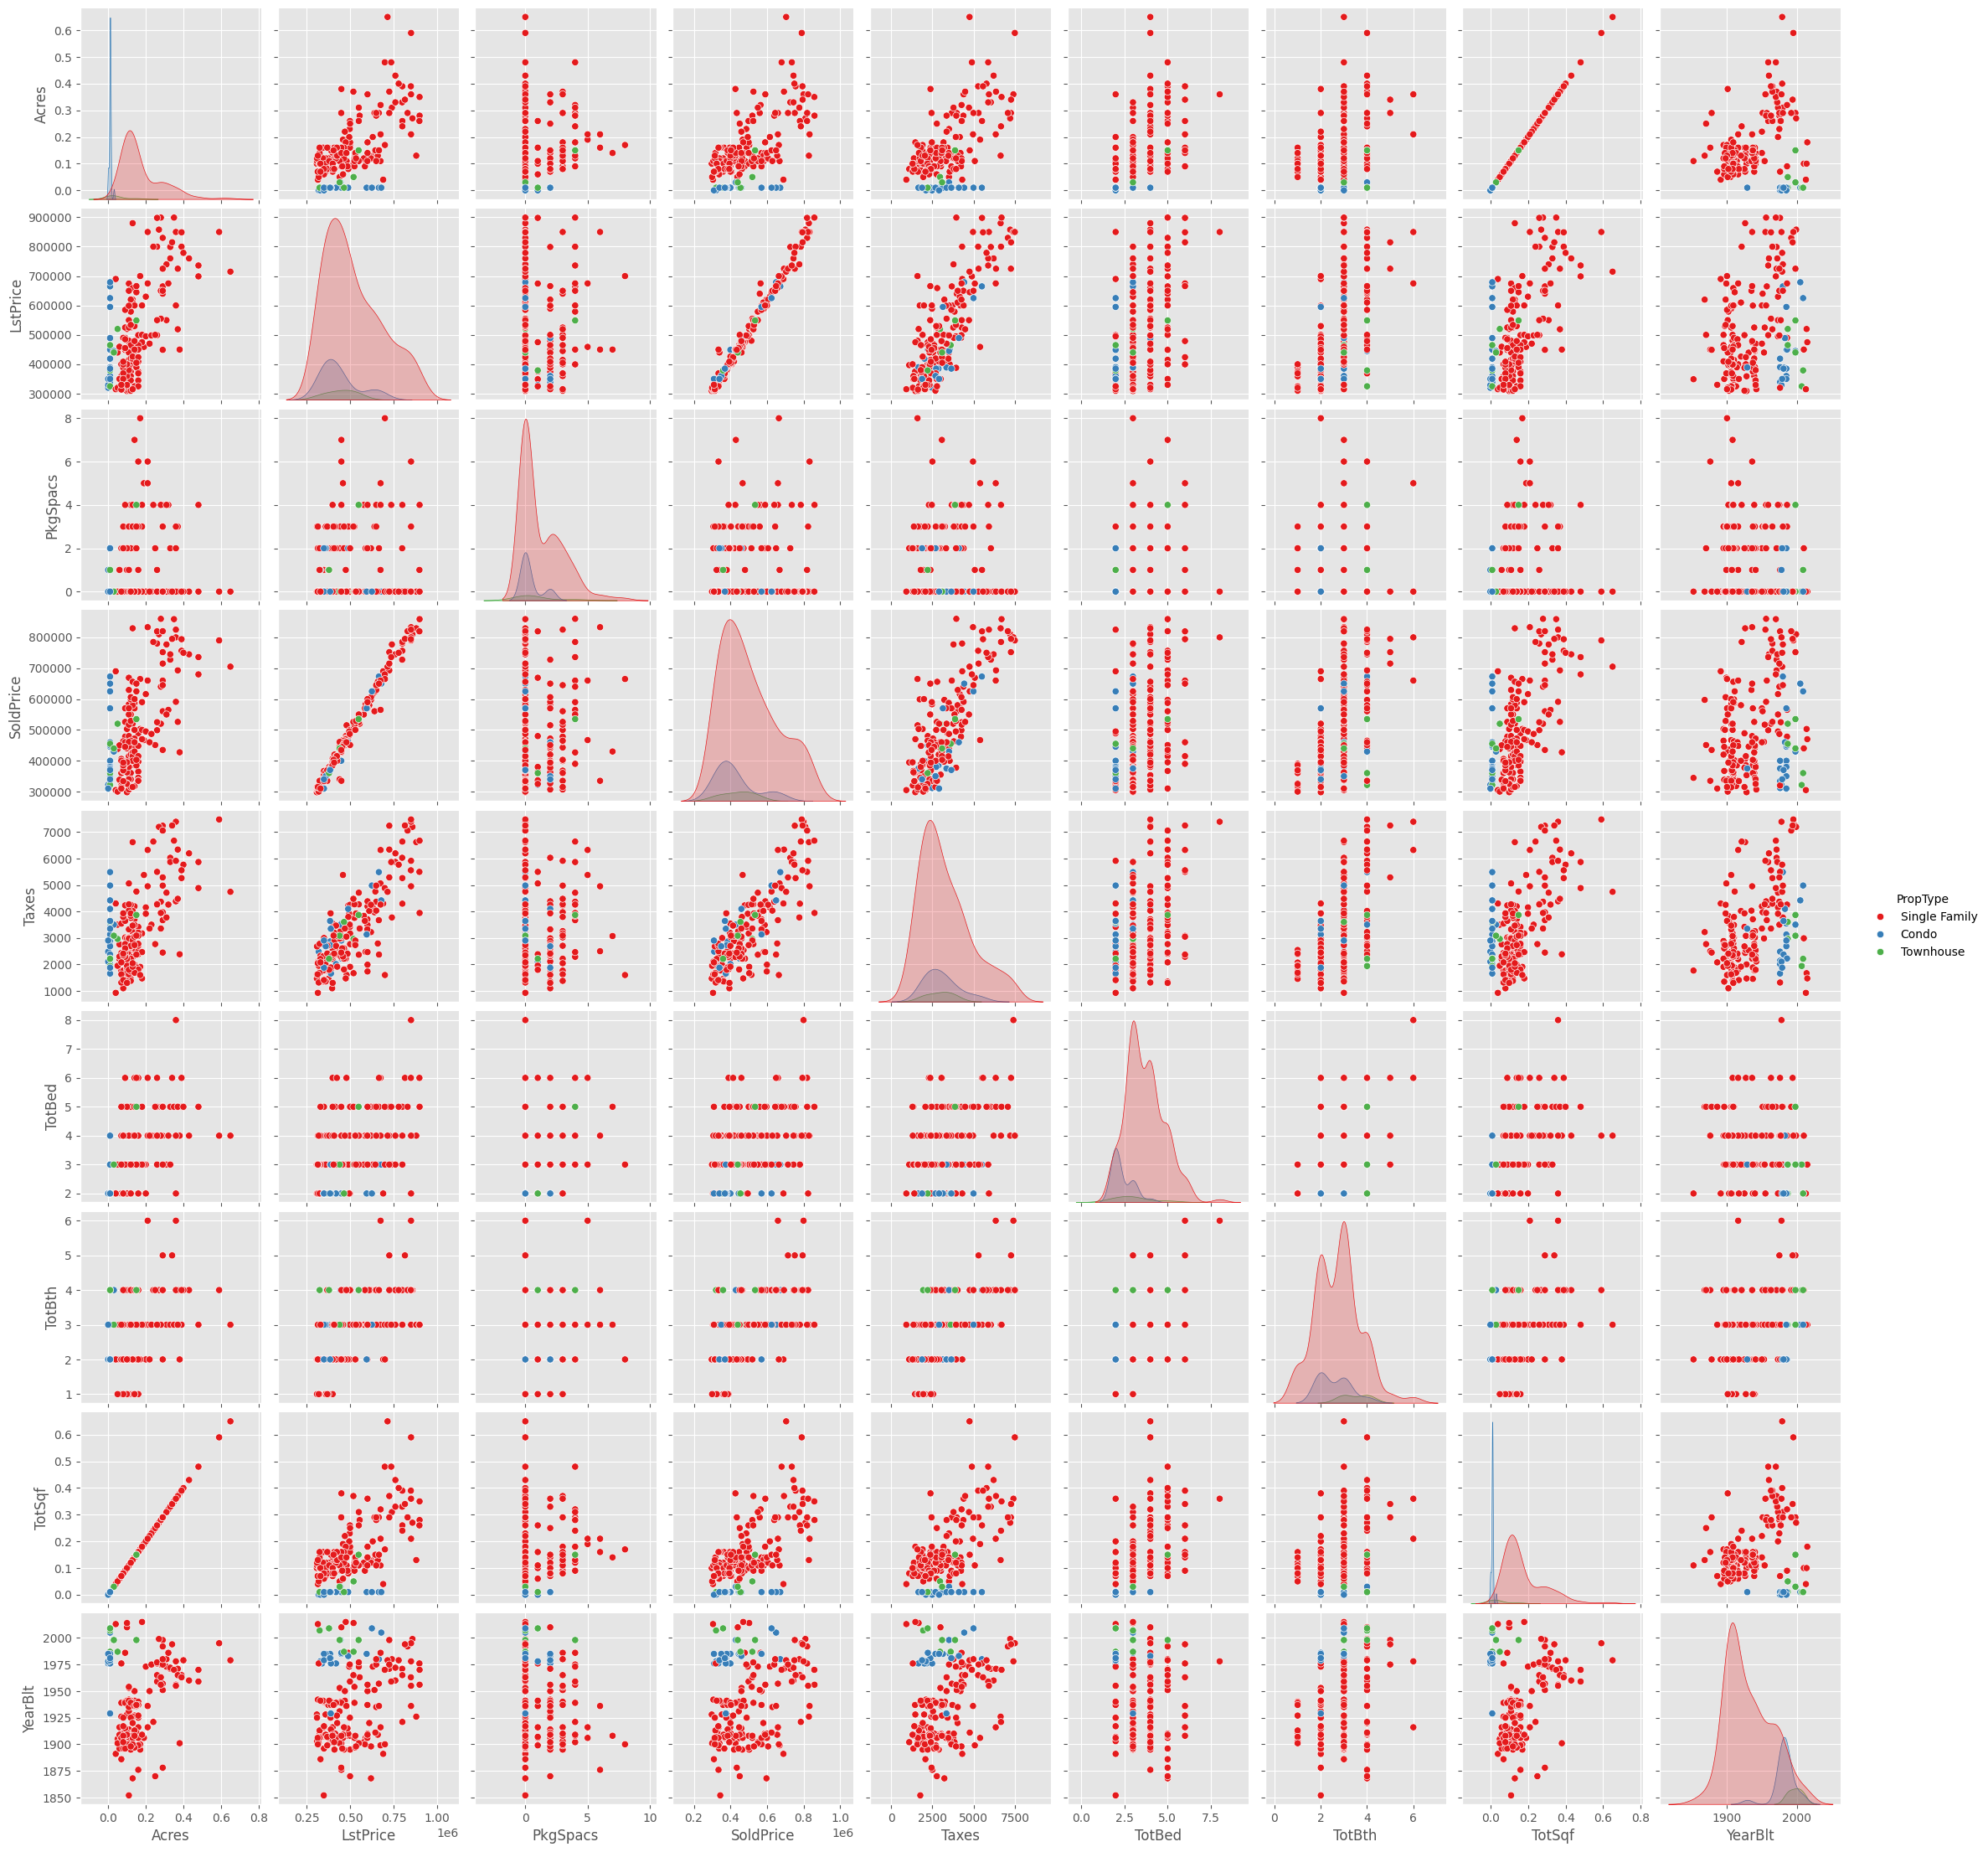

In [76]:
house_matrix = house_clean[['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'PropType']]

# Use seaborn to plot the scatter plot matrix
sns.pairplot(house_matrix, hue = 'PropType', palette='Set1')
plt.show()

**Your Interpretation:** 

Single familty homes are the most abundant property type. There are strong linear relationships between several columns such as acres, lstprice, taxes, and soldprice. The correlation between acres and totsqf is one, indicating these columns represent the same data. Additionally, the correlation between list price and sold price is very high, indicating there is not much change in price between the listing price and final sold price.

### Task 4: Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

What can you say about the relation between the location and the house price?  

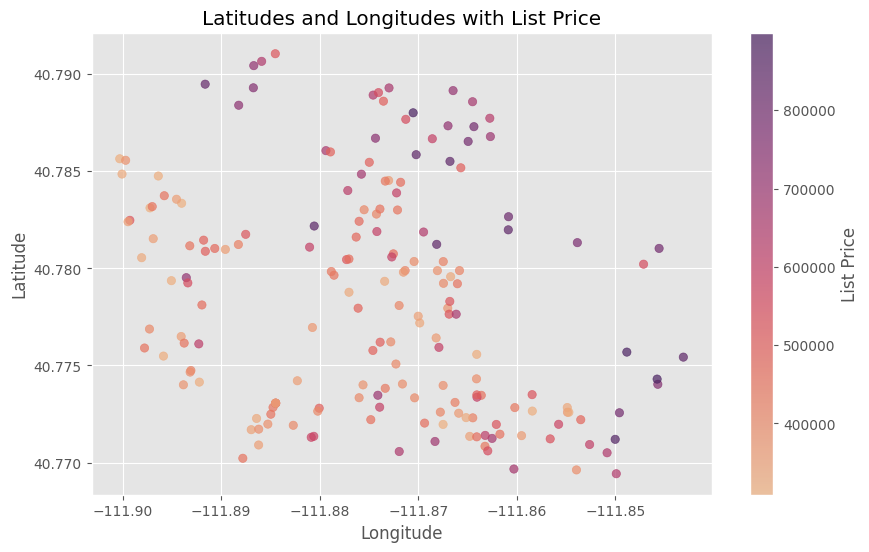

In [77]:
scatter = plt.scatter(house_clean['Longitude'], house_clean['Latitude'], c=house_clean['LstPrice'], cmap='flare', alpha=0.7)

# Adding colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('List Price')


plt.title('Latitudes and Longitudes with List Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)

plt.show()

**Your Interpretation:** 

Houses that are located with more north-eastern coordinates are typically more expensive than other locations.

### Task 5: Simple  Linear Regression 
Use the `ols` function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a scatterplot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [78]:
# Run OLS model
model_ols = sm.ols(formula='SoldPrice ~ LstPrice', data=house_clean).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.095e+04
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          6.71e-166
Time:                        14:31:54   Log-Likelihood:                -2099.3
No. Observations:                 186   AIC:                             4203.
Df Residuals:                     184   BIC:                             4209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.263e+04   4814.224      2.623      0.009    3128.709    2.21e+04
LstPrice       0.9488      0.009    104.665      0.000       0.931       0.967
==============================================================================
Omnibus:                       98.846   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.470
Skew:                          -1.866   Prob(JB):                    1.18e-155
Kurtosis:                      11.839   Cond. No.                     1.80e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

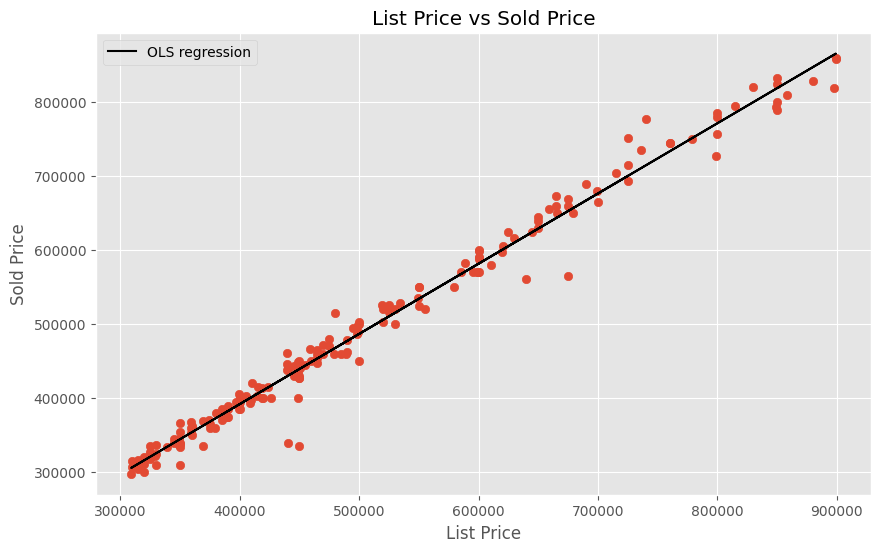

In [79]:
# Plot the OLS regression line
plt.scatter(house_clean['LstPrice'], house_clean['SoldPrice'])
plt.plot(house_clean["LstPrice"], model_ols.predict(), color = "black", label = "OLS regression")
plt.title('List Price vs Sold Price')
plt.xlabel('List Price')
plt.ylabel('Sold Price')
plt.legend()
plt.show()

**Your Interpretation:** 

The $R^2$ for this model is $R^2=98\%$ which indicates that this model accounts for 98% of the variance in the data. The slope of this line is $\beta_1 = 0.9488$ indicating that the relationship between list price and sold price is nearly 1:1.

### Task 6: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables.


**Question 1**: If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

Next look at the difference between list price and sold price explicitly. Calculate two new columns for your dataset. `DiffPriceAbsolute` and `DiffPriceRelative`.

* `DiffPriceAbsolute` - This is difference between sold price and list price. If it is positive, that means the house sold for more than it was listed at.
* `DiffPriceRelative` - This is the relative difference between sold price and list price. A value of 1.1 here means that the house sold for 110% of the asking price, and 0.9 means the house sold for 90% of the asking price.

Now, create two new models. One to predict `DiffPriceAbsolute`, and one to predict `DiffPriceRelative`. Use the same predictive variables as in the last model.


**Question 2**: Which of these two new models makes better predictions.

**Question 3**: Based on your answer to question two, why are these models different/the same.

To help justify your answer to question 3, train two models to predict `DiffPriceAbsolute` and `DiffPriceRelative` based on just `SoldPrice`. In addition, for each model make a scatterplots similar to Task 5 for these models.

In [80]:
# Multilinear regression model for significant variables
model_all_ols = sm.ols(formula="SoldPrice ~  Acres + Deck + GaragCap + Longitude + DaysOnMkt + Taxes + TotBed + TotBth + TotSqf", data=house_clean).fit()
# These variables produce the higest R-squared and adjusted R-squared values
model_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SoldPrice   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     65.00
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           9.14e-48
Time:                        14:31:54   Log-Likelihood:                -2265.0
No. Observations:                 179   AIC:                             4548.
Df Residuals:                     170   BIC:                             4577.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.499e+08   5.29e+07      2.833      0.005    4.55e+07    2.54e+08
Acres       1.138e+05   3.58e+04      3.177      0.002    4.31e+04    1.85e+05
Deck        2.253e+04   7304.080      3.085      0.002    8114.783     3.7e+04
GaragCap    1.906e+04   7596.454      2.508      0.013    4059.772    3.41e+04
Longitude   1.338e+06   4.73e+05      2.830      0.005    4.05e+05    2.27e+06
DaysOnMkt   -153.8520     79.854     -1.927      0.056    -311.486       3.782
Taxes         49.5283      6.453      7.676      0.000      36.791      62.266
TotBed      7849.4966   6722.201      1.168      0.245   -5420.241    2.11e+04
TotBth       1.69e+04   9079.405      1.861      0.064   -1023.450    3.48e+04
TotSqf      1.138e+05   3.58e+04      3.177      0.002    4.31e+04    1.85e+05
==============================================================================
Omnibus:                       26.636   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.715
Skew:                           0.874   Prob(JB):                     1.07e-08
Kurtosis:                       4.365   Cond. No.                     1.44e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [81]:
# Calculate
house_clean['DiffPriceAbsolute'] = house_clean['SoldPrice'] - house_clean['LstPrice']
house_clean['DiffPriceRelative'] = house_clean['SoldPrice'] / house_clean['LstPrice']


In [82]:
# Multilinear regression model for absolute price difference
model_all_ols = sm.ols(formula="DiffPriceAbsolute ~  Acres + Deck + GaragCap + Longitude + DaysOnMkt + Taxes + TotBed + TotBth + TotSqf", data=house_clean).fit()
model_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DiffPriceAbsolute   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     5.302
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           6.03e-06
Time:                        14:31:54   Log-Likelihood:                -2012.1
No. Observations:                 179   AIC:                             4042.
Df Residuals:                     170   BIC:                             4071.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.695e+07   1.29e+07     -1.316      0.190   -4.24e+07    8.48e+06
Acres      -6262.0032   8725.433     -0.718      0.474   -2.35e+04     1.1e+04
Deck       -2273.5901   1778.436     -1.278      0.203   -5784.253    1237.072
GaragCap   -3065.6864   1849.625     -1.657      0.099   -6716.877     585.504
Longitude  -1.516e+05   1.15e+05     -1.316      0.190   -3.79e+05    7.57e+04
DaysOnMkt    -58.8189     19.443     -3.025      0.003     -97.200     -20.437
Taxes         -0.7000      1.571     -0.446      0.656      -3.801       2.401
TotBed     -1885.3035   1636.757     -1.152      0.251   -5116.289    1345.682
TotBth      -294.9287   2210.702     -0.133      0.894   -4658.891    4069.033
TotSqf     -6261.9918   8725.433     -0.718      0.474   -2.35e+04     1.1e+04
==============================================================================
Omnibus:                       93.241   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.317
Skew:                          -1.852   Prob(JB):                    8.82e-130
Kurtosis:                      11.121   Cond. No.                     1.44e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [83]:
# Multilinear regression model for relative price difference
model_all_ols = sm.ols(formula="DiffPriceRelative ~  Acres + Deck + GaragCap + Longitude + DaysOnMkt + Taxes + TotBed + TotBth + TotSqf", data=house_clean).fit()
model_all_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DiffPriceRelative   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.866
Date:                Wed, 21 Feb 2024   Prob (F-statistic):            0.00514
Time:                        14:31:54   Log-Likelihood:                 343.83
No. Observations:                 179   AIC:                            -669.7
Df Residuals:                     170   BIC:                            -641.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1580     24.774     -0.370      0.712     -58.062      39.746
Acres         -0.0068      0.017     -0.406      0.685      -0.040       0.026
Deck          -0.0019      0.003     -0.561      0.575      -0.009       0.005
GaragCap      -0.0047      0.004     -1.315      0.190      -0.012       0.002
Longitude     -0.0908      0.221     -0.410      0.682      -0.528       0.346
DaysOnMkt     -0.0001   3.74e-05     -3.405      0.001      -0.000   -5.35e-05
Taxes       2.165e-06   3.02e-06      0.717      0.475    -3.8e-06    8.13e-06
TotBed        -0.0010      0.003     -0.316      0.753      -0.007       0.005
TotBth        -0.0037      0.004     -0.861      0.391      -0.012       0.005
TotSqf        -0.0068      0.017     -0.406      0.685      -0.040       0.026
==============================================================================
Omnibus:                      124.740   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1334.020
Skew:                          -2.462   Prob(JB):                    2.10e-290
Kurtosis:                      15.435   Cond. No.                     1.44e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Your Interpretation:** 

1. Our multilinear model's $R^2 = 75\%$ while the list price's $R^2 = 98\%$. This means that our model is not as effective at predicting sold price as the list price is.

2. The DiffAbsolutePrice model performed better than the DiffPriceRelative with $R^2 = 20\%$ and $R^2 = 12\%$ respectively, but both models perform relatively poor.

3. Since the DiffAbsolutePrice model has a scale tied to actual price points, the relationships are more apparent. The relative differences are a ratio which have a tighter distribution resulting in less variability.

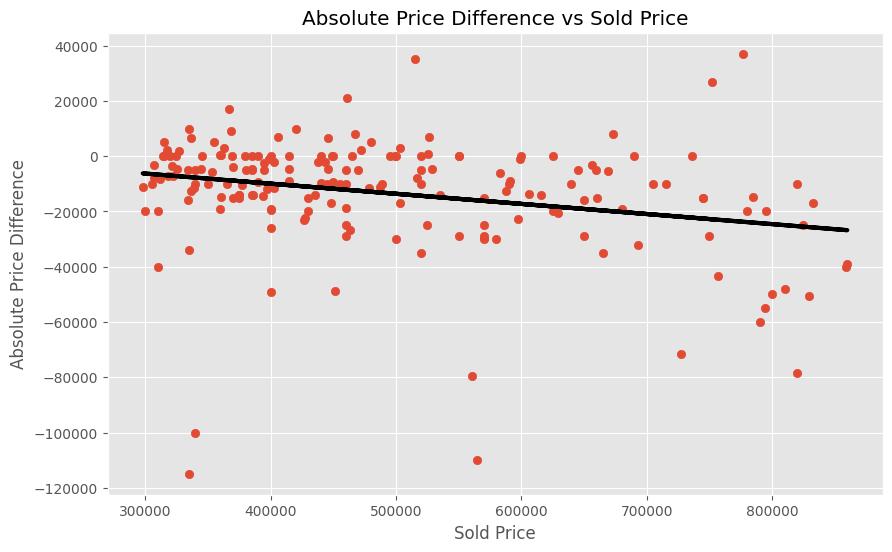

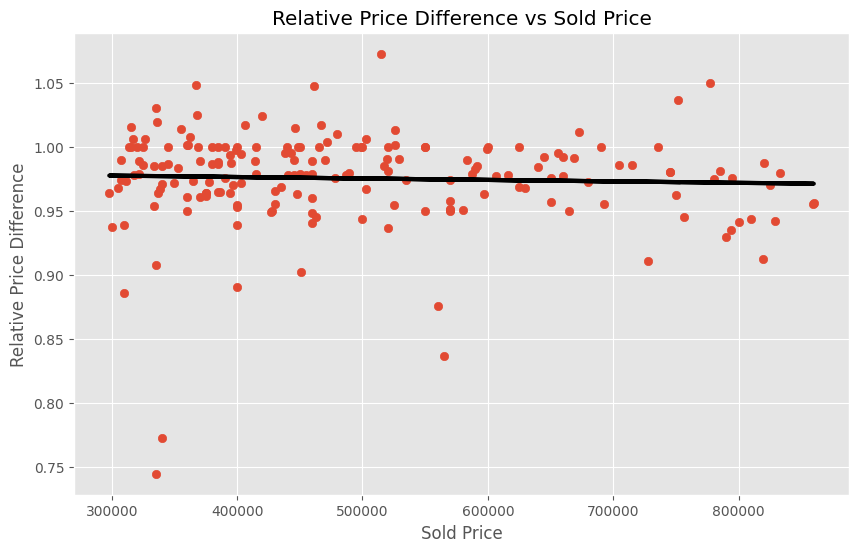

In [84]:
lr = linear_model.LinearRegression()

# DiffPriceAbsolute model
xa = house_clean['SoldPrice'].values.reshape(house_clean['SoldPrice'].shape[0],1)
ya = house_clean['DiffPriceAbsolute'].values.reshape(house_clean['DiffPriceAbsolute'].shape[0],1)

lr.fit(X=xa, y=ya)

plt.scatter(xa, ya)
plt.plot(xa, lr.predict(xa), color='black', linewidth=3)
plt.title('Absolute Price Difference vs Sold Price')
plt.xlabel('Sold Price')
plt.ylabel('Absolute Price Difference')
plt.show()

# DiffPriceRelative model
xb = house_clean['SoldPrice'].values.reshape(house_clean['SoldPrice'].shape[0],1)
yb = house_clean['DiffPriceRelative'].values.reshape(house_clean['DiffPriceRelative'].shape[0],1)

lr.fit(X=xb, y=yb)

plt.scatter(xb, yb)
plt.plot(xb, lr.predict(xb), color='black', linewidth=3)
plt.title('Relative Price Difference vs Sold Price')
plt.xlabel('Sold Price')
plt.ylabel('Relative Price Difference')
plt.show()

### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop\_Type\_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop\_Type\_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

                 TotSqf  Prop_Type_num  SoldPrice
TotSqf         1.000000      -0.434083   0.653944
Prop_Type_num -0.434083       1.000000  -0.170549
SoldPrice      0.653944      -0.170549   1.000000


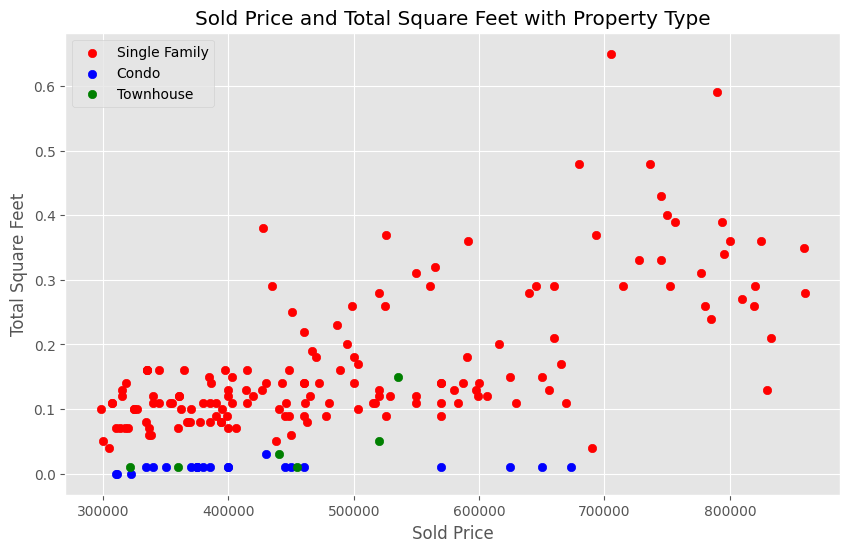

In [85]:
print(house_clean[[ "TotSqf", "Prop_Type_num", "SoldPrice"]].corr())

# Filter by property type
single_fam = house_clean[house_clean["Prop_Type_num"] == 0]
condo = house_clean[house_clean["Prop_Type_num"] == 1]
townhouse = house_clean[house_clean["Prop_Type_num"] == 2]

# plot scatter plot
plt.scatter(single_fam['SoldPrice'], single_fam['TotSqf'], c="red", label='Single Family')
plt.scatter(condo['SoldPrice'], condo['TotSqf'], c="blue", label='Condo')
plt.scatter(townhouse['SoldPrice'], townhouse['TotSqf'], c="green", label='Townhouse')
plt.title('Sold Price and Total Square Feet with Property Type')
plt.xlabel('Sold Price')
plt.ylabel('Total Square Feet')
plt.legend()
plt.grid(True)

plt.show()



**Your Interpretation:** 

The correlation between property type and total square feet is -0.43 which indicates that the influence of Property type on Sold Price can be incorrectly attributed to TotSqf. The scatterplot shows that condos and townhouses have very low TotSqf.